# Final Project
By: Louise Henningsson, Tejal Borade

In [1]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/gdrive
Mounted at /content/drive
/content/drive/MyDrive


In [3]:
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
healthy_articles = pd.read_csv('FundArticlesHealthy.csv').sample(1000)
list_healthy = list(healthy_articles['Healthy Fund Articles'].values)
unhealthy_articles = pd.read_csv('FundArticlesUnhealthy.csv').sample(1000)
list_unhealthy = list(unhealthy_articles['Unhealthy Fund Articles'].values)
summary_labels = pd.read_csv('MutualFundLabels.csv')
SUMMARY_PATH = '/content/drive/MyDrive/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/drive/MyDrive/MutualFundLabels.csv'
DIRECTORY = '.'
HEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesHealthy.csv")
UNHEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesUnhealthy.csv")

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'


In [5]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/content/drive/MyDrive', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/content/drive/MyDrive', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

Creating stopwords:

In [7]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

Creating Word Vectors:

Reading and Formating data:

In [9]:
fund_names, summaries = get_data(SUMMARY_PATH)

In [10]:
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence

In [11]:
words = np.concatenate([tokenizer(summary) for summary in summaries])
print(words[:20])

['ab' 'arizona' 'portfolio' 'investment' 'objective' 'investment'
 'objective' 'portfolio' 'earn' 'highest' 'level' 'current' 'income'
 'exempt' 'federal' 'income' 'tax' 'state' 'arizona' 'personal']


Skip Gram model inputs:

In [12]:
size_batch = 128
num_epochs = 2

# Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocab_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
skips_num = 4 # How many times to reuse an input to generate a label

In [13]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(words).most_common(max_vocab_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [14]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [15]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 3449


In [16]:
data = list()
unk_count = 0
for word in words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [17]:
print(data[:20])

[1284, 0, 7, 3, 123, 3, 123, 7, 1085, 289, 471, 181, 26, 563, 77, 26, 61, 264, 0, 1087]


In [18]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [19]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

# Training Skim-Gram Model:

In [20]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [21]:
encoder, autoencoder = creat_word2vec_model()

In [22]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3449)]            0         
                                                                 
 dense (Dense)               (None, 50)                172500    
                                                                 
 dense_1 (Dense)             (None, 3449)              175899    
                                                                 
Total params: 348,399
Trainable params: 348,399
Non-trainable params: 0
_________________________________________________________________


In [23]:
autoencoder.fit_generator(batch_generator(size_batch, skips_num, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / size_batch), epochs=num_epochs)

Epoch 1/2


<ipython-input-23-58e2946973a0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(size_batch, skips_num, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / size_batch), epochs=num_epochs)


7481/7481 [==============================] - 236s 31ms/step - loss: 0.0125
Epoch 2/2
7481/7481 [==============================] - 242s 32ms/step - loss: 0.0021


In [24]:
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [25]:
word2vec = {w : vecotrize(w) for w in word2id.keys()}

1/1 [==============================] - 0s 25ms/step


In [26]:
save_word2vec(our_word2vec)

In [27]:
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [28]:
words_neighbors_1 = get_n_closer('expenses', 10, word2vec)
print('words close to expenses : ' +str(', '.join(words_neighbors_1)))
words_neighbors_2 = get_n_closer('derivatives', 10, word2vec)
print('words close to derivatives : ' +str(', '.join(words_neighbors_2)))

words close to expenses : expenses, total, operating, annual, fees, reflected, table, describes, expenses1, following
words close to derivatives : derivatives, municipalities, predicted, true, pacific, guam, tax-exempt, relate, relating, behind


In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(3449, 50)
(3449, 2)


In [30]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

In [31]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])
    
    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['fee', 'swaps'], 10, word2vec)

# Decide keywords for Investment Strategies:
And creating knowledge bases:

In [32]:
key_words = ['mutual', 'funds', 'ETFs', 'domestic', 'international', 'equity', 'fixed', 'income', 'alternative', 'open-end', 'closed-end', 'derivatives', 'futures', 'swaps', 'structured'] # Balanced Fund (Low Risk)
key_words2 = ['bond', 'bonds', 'caps', ' debt', 'securities', 'investment', 'grade', 'rate', 'rates', 'derivative', 'derivatives', 'yield', 'mortgage', 'duration', 'interest', 'credit', 'swap', 'swaps'] # Fixed Income Long Only (Low Risk)
key_words3 = ['dividend', 'dividends', 'common', 'stock', 'stocks', 'companies', 'SP500', 'equity', 'equities', 'share', 'shares', 'insurance', 'liquid'] # Equity Long Only (Low Risk)
key_words4 = ['mortgage', 'assets', 'long', 'short', 'residential', 'commercial', 'derivatives', 'forward', 'contract', 'contracts', 'option', 'options', 'futures', 'swap', 'swaps', ' principal', 'credit', 'default', 'hedge'] # Long Short Funds (High Risk)

In [33]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [34]:
knowledge_base = create_knowledge_base(5, word2vec, key_words)
knowledge_base2 = create_knowledge_base(5, word2vec, key_words2)
knowledge_base3 = create_knowledge_base(5, word2vec, key_words3)
knowledge_base4 = create_knowledge_base(5, word2vec, key_words4)

ETFs not in word2vec


 debt not in word2vec


SP500 not in word2vec


 principal not in word2vec


In [35]:
print(knowledge_base)

{'fidelity®', 'lending', 'hedged', 'income', 'downside', 'marginal', 'predicted', 'futures', 'global', 'mutual', 'last', 'funds', 'includes', 'brown', 'anticipate', 'swaps', 'ordinary', 'relationship', 'bond', 'cap', 'effective', 'adding', 'ETFs', 'reit', 'esg', 'desirable', 'structured', '3rd', 'bears', 'requirement', 'stabilize', 'represents', 'open-end', 'proportions', 'broker/dealers', 'pacific', 'international', 'true', 'large', 'floating', 'tax', 'buyer', 'inclusion', 'employed', 'alternative', 'domestic', 'mulally', 'unpredictable', 'small', 'closed-end', 'short-term', 'entitled', 'equity', 'mid', 'gains', 'decisions', 'american', 'characteristic', 'principally', 'municipalities', 'long', 'civil', 'lines', 'reset', 'treatment', 'derivatives', 'fixed'}


Creatin Data Frame:

In [36]:
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df_label = df_label[df_label['fund_name']!= 'Columbia Commodity Strategy Fund']
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()
df_label2 = df[df['Ivestment Strategy'] == 'Long Short Funds (High Risk)']
df = df[df['Ivestment Strategy']!= 'Long Short Funds (High Risk)']
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [37]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return np.mean(sentence_scores)

In [38]:
df['deriv_sentences_match1'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
df['deriv_sentences_match2'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base2, num_sent=5), axis=1)
df['deriv_sentences_match3'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base3, num_sent=5), axis=1)
df['deriv_sentences_match4'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base4, num_sent=5), axis=1)

In [39]:
df_label2['deriv_sentences_match1'] = df_label2.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
df_label2['deriv_sentences_match2'] = df_label2.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base2, num_sent=5), axis=1)
df_label2['deriv_sentences_match3'] = df_label2.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base3, num_sent=5), axis=1)
df_label2['deriv_sentences_match4'] = df_label2.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base4, num_sent=5), axis=1)

Creating X, Y, train, validation, and test variables:

In [40]:
X = df[['deriv_sentences_match1','deriv_sentences_match2','deriv_sentences_match3','deriv_sentences_match4']].values

In [41]:
y = []
for i in df['Ivestment Strategy']:
  if i == 'Balanced Fund (Low Risk)':
    y.append(1)
  elif i == 'Fixed Income Long Only (Low Risk)':
    y.append(2)
  else:
    y.append(3)

In [42]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
len(train_x)

322

In [44]:
val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.5, random_state=42)

In [45]:
train_x = np.append(train_x, [df_label2[['deriv_sentences_match1','deriv_sentences_match2','deriv_sentences_match3','deriv_sentences_match4']].iloc[0]], axis = 0)
train_x = np.append(train_x, [df_label2[['deriv_sentences_match1','deriv_sentences_match2','deriv_sentences_match3','deriv_sentences_match4']].iloc[1]], axis = 0)
val_x = np.append(val_x, [df_label2[['deriv_sentences_match1','deriv_sentences_match2','deriv_sentences_match3','deriv_sentences_match4']].iloc[2]], axis = 0)
test_x = np.append(test_x, [df_label2[['deriv_sentences_match1','deriv_sentences_match2','deriv_sentences_match3','deriv_sentences_match4']].iloc[3]], axis = 0)

In [46]:
len(train_x)

324

In [47]:
train_y = np.append(train_y, 4)
train_y = np.append(train_y, 4)
val_y = np.append(val_y, 4)
test_y = np.append(test_y, 4)

# Predictors for 4 Investment Strategies:


### Kernel SVM:

In [103]:
# Defining scaler to later scale data in predictors.
scaler = StandardScaler()

In [104]:
classifierSVC = SVC(C=1, kernel = 'rbf', gamma=0.85, probability=True)
model_svm = Pipeline([('standardize', scaler), ('svm', classifierSVC)])
# Fit on training set
model_svm.fit(train_x, train_y)

Pipeline(steps=[('standardize', StandardScaler()),
                ('svm', SVC(C=1, gamma=0.85, probability=True))])

Validation SVM:

In [105]:
valY_hat = model_svm.predict(val_x)
valY_hat_probs = model_svm.predict_proba(val_x)[:,1]
val_accuracy = accuracy_score(val_y, valY_hat) * 100
val_f1 = f1_score(val_y, valY_hat, average='weighted') * 100
val_confusion = confusion_matrix(val_y, valY_hat)
print('Validation Confusion matrix SVM:\n', val_confusion)
print('Validation accuracy SVM: %.4f%%' % val_accuracy)
print('Validation F1 score SVM: %.4f %%' % val_f1)

Validation Confusion matrix SVM:
 [[ 9  1  5  0]
 [ 3 15  3  0]
 [ 0  0 33  0]
 [ 0  1  0  0]]
Validation accuracy SVM: 81.4286%
Validation F1 score SVM: 80.0163 %


Prediction SVM:

In [51]:
# Prediction
y_pred_SVC = model_svm.predict(test_x)

In [52]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred_SVC))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y, y_pred_SVC))

Confusion Matrix:
 [[ 8  3  1  0]
 [ 2 15  7  0]
 [ 0  1 33  0]
 [ 0  0  1  0]]

Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.67      0.73        12
           2       0.79      0.62      0.70        24
           3       0.79      0.97      0.87        34
           4       0.00      0.00      0.00         1

    accuracy                           0.79        71
   macro avg       0.59      0.57      0.57        71
weighted avg       0.78      0.79      0.77        71



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN:

In [53]:
knn = KNeighborsClassifier()
model_knn = Pipeline([('standardize', scaler), ('knn', knn)])
model_knn.fit(train_x, train_y)

Pipeline(steps=[('standardize', StandardScaler()),
                ('knn', KNeighborsClassifier())])

Validation of KNN:

In [54]:
valY_hat_knn = model_knn.predict(val_x)
valY_hat_probs_knn = model_knn.predict_proba(val_x)[:,1]
val_accuracy_knn = accuracy_score(val_y, valY_hat_knn) * 100
val_f1_knn = f1_score(val_y, valY_hat_knn, average='weighted') * 100
val_confusion_knn = confusion_matrix(val_y, valY_hat_knn)
print('Validation Confusion matrix KNN:\n', val_confusion_knn)
print('Validation accuracy KNN: %.4f%%' % val_accuracy_knn)
print('Validation F1 score KNN: %.4f %%' % val_f1_knn)

Validation Confusion matrix KNN:
 [[ 9  1  5  0]
 [ 6 14  1  0]
 [ 1  1 31  0]
 [ 0  1  0  0]]
Validation accuracy KNN: 77.1429%
Validation F1 score KNN: 76.3028 %


Predicion KNN:

In [55]:
# Prediction
y_pred_knn = model_knn.predict(test_x)

In [56]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred_knn))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y, y_pred_knn))

Confusion Matrix:
 [[ 9  2  1  0]
 [ 4 16  4  0]
 [ 0  2 32  0]
 [ 0  0  1  0]]

Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.75      0.72        12
           2       0.80      0.67      0.73        24
           3       0.84      0.94      0.89        34
           4       0.00      0.00      0.00         1

    accuracy                           0.80        71
   macro avg       0.58      0.59      0.58        71
weighted avg       0.79      0.80      0.79        71



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree:

In [57]:
clf_test = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 3, min_samples_split = 5) # through trial and error, have changed the the vales inside.
model_clf = Pipeline([('standardize', scaler), ('clf', clf_test)])
model_clf.fit(train_x, train_y)

Pipeline(steps=[('standardize', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(max_depth=15, min_samples_leaf=3,
                                        min_samples_split=5))])

Validation Decision Tree:

In [58]:
valY_hat_clf = model_clf.predict(val_x)
valY_hat_probs_clf = model_clf.predict_proba(val_x)[:,1]
val_accuracy_clf = accuracy_score(val_y, valY_hat_clf) * 100
val_f1_clf = f1_score(val_y, valY_hat_clf, average='weighted') * 100
val_confusion_clf = confusion_matrix(val_y, valY_hat_clf)
print('Validation Confusion matrix Decision Tree:\n', val_confusion_clf)
print('Validation accuracy Decision Tree: %.4f%%' % val_accuracy_clf)
print('Validation F1 score Decision Tree: %.4f %%' % val_f1_clf)

Validation Confusion matrix Decision Tree:
 [[10  0  5  0]
 [ 2 15  4  0]
 [ 1  3 29  0]
 [ 0  1  0  0]]
Validation accuracy Decision Tree: 77.1429%
Validation F1 score Decision Tree: 76.3172 %


Prediction Decision Tree:

In [59]:
# Prediction
y_pred_clf = model_clf.predict(test_x)

In [60]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred_clf))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y, y_pred_clf))

Confusion Matrix:
 [[ 7  3  2  0]
 [ 3 15  6  0]
 [ 0  5 29  0]
 [ 0  0  1  0]]

Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.58      0.64        12
           2       0.65      0.62      0.64        24
           3       0.76      0.85      0.81        34
           4       0.00      0.00      0.00         1

    accuracy                           0.72        71
   macro avg       0.53      0.52      0.52        71
weighted avg       0.70      0.72      0.71        71



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression:

In [61]:
lr = LogisticRegression(max_iter = 100)
model_lr = Pipeline([('standardize', scaler), ('log_reg', lr)]) # got his from svm code
model_lr.fit(train_x, train_y)

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg', LogisticRegression())])

Validation Logistic Regression:

In [62]:
valY_hat_lr = model_lr.predict(val_x)
valY_hat_probs_lr = model_lr.predict_proba(val_x)[:,1]
val_accuracy_lr = accuracy_score(val_y, valY_hat_lr) * 100
val_f1_lr = f1_score(val_y, valY_hat_lr, average='weighted') * 100
val_confusion_lr = confusion_matrix(val_y, valY_hat_lr)
print('Validation Confusion matrix Logistic Regression:\n', val_confusion_lr)
print('Validation accuracy Logistic Regression: %.4f%%' % val_accuracy_lr)
print('Validation F1 score Logistic Regression: %.4f %%' % val_f1_lr)

Validation Confusion matrix Logistic Regression:
 [[ 9  1  5  0]
 [ 5 14  2  0]
 [ 1  1 31  0]
 [ 0  1  0  0]]
Validation accuracy Logistic Regression: 77.1429%
Validation F1 score Logistic Regression: 76.1294 %


Prediction Logistic Regression:

In [63]:
# Prediction
y_pred_lr = model_lr.predict(test_x)

In [64]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred_lr))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y, y_pred_lr))

Confusion Matrix:
 [[ 7  4  1  0]
 [ 6 14  4  0]
 [ 0  1 33  0]
 [ 0  0  1  0]]

Classification Report:
               precision    recall  f1-score   support

           1       0.54      0.58      0.56        12
           2       0.74      0.58      0.65        24
           3       0.85      0.97      0.90        34
           4       0.00      0.00      0.00         1

    accuracy                           0.76        71
   macro avg       0.53      0.53      0.53        71
weighted avg       0.75      0.76      0.75        71



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest:

In [65]:
forest_test=RandomForestClassifier(n_estimators=100,max_depth=15,min_samples_leaf = 3, min_samples_split = 5) # through trial and error, have changed the the vales inside.
model_forest = Pipeline([('standardize', scaler), ('rand_for', forest_test)])
model_forest.fit(train_x, train_y)

Pipeline(steps=[('standardize', StandardScaler()),
                ('rand_for',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=3,
                                        min_samples_split=5))])

In [66]:
valY_hat_rf = model_forest.predict(val_x)
valY_hat_probs_rf = model_forest.predict_proba(val_x)[:,1]
val_accuracy_rf = accuracy_score(val_y, valY_hat_rf) * 100
val_f1_rf = f1_score(val_y, valY_hat_rf, average='weighted') * 100
val_confusion_rf = confusion_matrix(val_y, valY_hat_rf)
print('Validation Confusion matrix Random Forest:\n', val_confusion_rf)
print('Validation accuracy Random Forest: %.4f%%' % val_accuracy_rf)
print('Validation F1 score Random Forest: %.4f %%' % val_f1_rf)

Validation Confusion matrix Random Forest:
 [[10  1  4  0]
 [ 3 16  2  0]
 [ 0  0 33  0]
 [ 0  1  0  0]]
Validation accuracy Random Forest: 84.2857%
Validation F1 score Random Forest: 83.1358 %


In [67]:
# Prediction
y_pred_rf = model_forest.predict(test_x)

In [68]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred_rf))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y, y_pred_rf))

Confusion Matrix:
 [[ 8  3  1  0]
 [ 2 16  6  0]
 [ 0  1 33  0]
 [ 0  0  1  0]]

Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.67      0.73        12
           2       0.80      0.67      0.73        24
           3       0.80      0.97      0.88        34
           4       0.00      0.00      0.00         1

    accuracy                           0.80        71
   macro avg       0.60      0.58      0.58        71
weighted avg       0.79      0.80      0.79        71



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Classification of 3 types of Investment Strategies, EXCLUDING Long Short Funds (High Risk):

In [69]:
# Creating new dataframe without Long Short Funds (High Risk)
df_extraction_new = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label_new = pd.read_csv(SUMMARY_LABELS_PATH)
df_label_new = df_label[df_label['fund_name']!= 'Columbia Commodity Strategy Fund']
df_new = df_label.merge(df_extraction, on='fund_name', how='left').dropna()
df_new = df[df['Ivestment Strategy']!= 'Long Short Funds (High Risk)']
df_new.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary,deriv_sentences_match1,deriv_sentences_match2,deriv_sentences_match3,deriv_sentences_match4
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...,0.818182,1.561983,0.586777,0.239669
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...,0.708955,1.574627,0.776119,0.238806
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...,0.723077,1.600000,0.769231,0.215385
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...,0.781513,1.521008,0.756303,0.201681
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...,0.781513,1.521008,0.756303,0.201681


In [70]:
df_new['deriv_sentences_match_new1'] = df_new.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
df_new['deriv_sentences_match_new2'] = df_new.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base2, num_sent=5), axis=1)
df_new['deriv_sentences_match_new3'] = df_new.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base3, num_sent=5), axis=1)

Creating new X, Y, train, validation, and test variables:

In [71]:
X_new = df_new[['deriv_sentences_match_new1','deriv_sentences_match_new2','deriv_sentences_match_new3']].values

In [72]:
y_new = []
for i in df_new['Ivestment Strategy']:
  if i == 'Balanced Fund (Low Risk)':
    y_new.append(1)
  elif i == 'Fixed Income Long Only (Low Risk)':
    y_new.append(2)
  else:
    y_new.append(3)

In [73]:
train_x_new, test_x_new, train_y_new, test_y_new = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [74]:
val_x_new, test_x_new, val_y_new, test_y_new = train_test_split(test_x_new, test_y_new, test_size=0.5, random_state=42)

### SVM Model:

In [75]:
classifierSVC_new = SVC(C=1, kernel = 'rbf', gamma=0.85, probability=True)
model_svm_new = Pipeline([('standardize', scaler), ('svm', classifierSVC_new)])
# Fit on training set
model_svm_new.fit(train_x_new, train_y_new)

Pipeline(steps=[('standardize', StandardScaler()),
                ('svm', SVC(C=1, gamma=0.85, probability=True))])

Validation SVM:

In [76]:
valY_hat_svm_new = model_svm_new.predict(val_x_new)
valY_hat_probs_svm_new = model_svm_new.predict_proba(val_x_new)[:,1]
val_accuracy_svm_new = accuracy_score(val_y_new, valY_hat_svm_new) * 100
val_f1_svm_new = f1_score(val_y_new, valY_hat_svm_new, average='weighted') * 100
val_confusion_svm_new = confusion_matrix(val_y_new, valY_hat_svm_new)
print('Validation Confusion matrix SVM:\n', val_confusion_svm_new)
print('Validation accuracy SVM: %.4f%%' % val_accuracy_svm_new)
print('Validation F1 score SVM: %.4f %%' % val_f1_svm_new)

Validation Confusion matrix SVM:
 [[12  0  3]
 [ 2 16  3]
 [ 2  0 31]]
Validation accuracy SVM: 85.5072%
Validation F1 score SVM: 85.5125 %


Prediction SVM:

In [77]:
# Prediction
y_pred_SVC_new = model_svm_new.predict(test_x_new)

In [78]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y_new, y_pred_SVC_new))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y_new, y_pred_SVC_new))

Confusion Matrix:
 [[ 8  2  2]
 [ 3 16  5]
 [ 2  1 31]]

Classification Report:
               precision    recall  f1-score   support

           1       0.62      0.67      0.64        12
           2       0.84      0.67      0.74        24
           3       0.82      0.91      0.86        34

    accuracy                           0.79        70
   macro avg       0.76      0.75      0.75        70
weighted avg       0.79      0.79      0.78        70



### KNN:

In [79]:
knn_new = KNeighborsClassifier()
model_knn_new = Pipeline([('standardize', scaler), ('knn', knn_new)])
model_knn_new.fit(train_x_new, train_y_new)

Pipeline(steps=[('standardize', StandardScaler()),
                ('knn', KNeighborsClassifier())])

Validation KNN:

In [80]:
valY_hat_knn_new = model_knn_new.predict(val_x_new)
valY_hat_probs_knn_new = model_knn_new.predict_proba(val_x_new)[:,1]
val_accuracy_knn_new = accuracy_score(val_y_new, valY_hat_knn_new) * 100
val_f1_knn_new = f1_score(val_y_new, valY_hat_knn_new, average='weighted') * 100
val_confusion_knn_new = confusion_matrix(val_y_new, valY_hat_knn_new)
print('Validation Confusion matrix KNN:\n', val_confusion_knn_new)
print('Validation accuracy KNN: %.4f%%' % val_accuracy_knn_new)
print('Validation F1 score KNN: %.4f %%' % val_f1_knn_new)

Validation Confusion matrix KNN:
 [[12  1  2]
 [ 4 16  1]
 [ 3  0 30]]
Validation accuracy KNN: 84.0580%
Validation F1 score KNN: 84.4528 %


Prediction KNN:

In [81]:
# Prediction
y_pred_knn_new = model_knn_new.predict(test_x_new)

In [82]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y_new, y_pred_knn_new))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y_new, y_pred_knn_new))

Confusion Matrix:
 [[ 9  1  2]
 [ 4 15  5]
 [ 2  2 30]]

Classification Report:
               precision    recall  f1-score   support

           1       0.60      0.75      0.67        12
           2       0.83      0.62      0.71        24
           3       0.81      0.88      0.85        34

    accuracy                           0.77        70
   macro avg       0.75      0.75      0.74        70
weighted avg       0.78      0.77      0.77        70



### Decision Tree:

In [83]:
clf_test_new = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 3, min_samples_split = 5) # through trial and error, have changed the the vales inside.
model_clf_new = Pipeline([('standardize', scaler), ('clf', clf_test_new)])
model_clf_new.fit(train_x_new, train_y_new)

Pipeline(steps=[('standardize', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(max_depth=15, min_samples_leaf=3,
                                        min_samples_split=5))])

Validation Decision Tree:

In [84]:
valY_hat_clf_new = model_knn_new.predict(val_x_new)
valY_hat_probs_clf_new = model_knn_new.predict_proba(val_x_new)[:,1]
val_accuracy_clf_new = accuracy_score(val_y_new, valY_hat_clf_new) * 100
val_f1_clf_new = f1_score(val_y_new, valY_hat_clf_new, average='weighted') * 100
val_confusion_clf_new = confusion_matrix(val_y_new, valY_hat_clf_new)
print('Validation Confusion matrix Decision Tree:\n', val_confusion_clf_new)
print('Validation accuracy Decision Tree: %.4f %%' % val_accuracy_clf_new)
print('Validation F1 score Decision Tree: %.4f %%' % val_f1_clf_new)

Validation Confusion matrix Decision Tree:
 [[12  1  2]
 [ 4 16  1]
 [ 3  0 30]]
Validation accuracy Decision Tree: 84.0580 %
Validation F1 score Decision Tree: 84.4528 %


Prediction Decision Tree:

In [85]:
# Prediction
y_pred_clf_new = model_clf_new.predict(test_x_new)

In [86]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y_new, y_pred_clf_new))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y_new, y_pred_clf_new))

Confusion Matrix:
 [[ 8  2  2]
 [ 3 14  7]
 [ 1  2 31]]

Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.67      0.67        12
           2       0.78      0.58      0.67        24
           3       0.78      0.91      0.84        34

    accuracy                           0.76        70
   macro avg       0.74      0.72      0.72        70
weighted avg       0.76      0.76      0.75        70



### Logistic Regression:

In [87]:
lr_new = LogisticRegression(max_iter = 10000)
model_lr_new = Pipeline([('standardize', scaler), ('log_reg', lr_new)]) # got his from svm code
model_lr_new.fit(train_x_new, train_y_new)

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg', LogisticRegression(max_iter=10000))])

Validation LR:

In [88]:
valY_hat_lr_new = model_lr_new.predict(val_x_new)
valY_hat_probs_lr_new = model_lr_new.predict_proba(val_x_new)[:,1]
val_accuracy_lr_new = accuracy_score(val_y_new, valY_hat_lr_new) * 100
val_f1_lr_new = f1_score(val_y_new, valY_hat_lr_new, average='weighted') * 100
val_confusion_lr_new = confusion_matrix(val_y_new, valY_hat_lr_new)
print('Validation Confusion matrix Logistic Regression:\n', val_confusion_lr_new)
print('Validation accuracy Logistic Regression: %.4f %%' % val_accuracy_lr_new)
print('Validation F1 score Logistic Regression: %.4f %%' % val_f1_lr_new)

Validation Confusion matrix Logistic Regression:
 [[10  1  4]
 [ 2 16  3]
 [ 2  0 31]]
Validation accuracy Logistic Regression: 82.6087 %
Validation F1 score Logistic Regression: 82.3854 %


Prediction LR:

In [89]:
# Prediction
y_pred_lr_new = model_lr_new.predict(test_x_new)

In [90]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y_new, y_pred_lr_new))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y_new, y_pred_lr_new))

Confusion Matrix:
 [[ 7  4  1]
 [ 3 15  6]
 [ 1  1 32]]

Classification Report:
               precision    recall  f1-score   support

           1       0.64      0.58      0.61        12
           2       0.75      0.62      0.68        24
           3       0.82      0.94      0.88        34

    accuracy                           0.77        70
   macro avg       0.74      0.72      0.72        70
weighted avg       0.76      0.77      0.76        70



### Random Forest:

In [91]:
forest_test_new = RandomForestClassifier(n_estimators=100,max_depth=15,min_samples_leaf = 3, min_samples_split = 5) # through trial and error, have changed the the vales inside.
model_forest_new = Pipeline([('standardize', scaler), ('rand_for', forest_test_new)])
model_forest_new.fit(train_x_new, train_y_new)

Pipeline(steps=[('standardize', StandardScaler()),
                ('rand_for',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=3,
                                        min_samples_split=5))])

Validation Random Forest:

In [92]:
valY_hat_rf_new = model_forest_new.predict(val_x_new)
valY_hat_probs_rf_new = model_forest_new.predict_proba(val_x_new)[:,1]
val_accuracy_rf_new = accuracy_score(val_y_new, valY_hat_rf_new) * 100
val_f1_rf_new = f1_score(val_y_new, valY_hat_rf_new, average='weighted') * 100
val_confusion_rf_new = confusion_matrix(val_y_new, valY_hat_rf_new)
print('Validation Confusion matrix Random Forest:\n', val_confusion_rf_new)
print('Validation accuracy Random Forest: %.4f %%' % val_accuracy_rf_new)
print('Validation F1 score Random Forest: %.4f %%' % val_f1_rf_new)

Validation Confusion matrix Random Forest:
 [[ 9  1  5]
 [ 2 15  4]
 [ 0  1 32]]
Validation accuracy Random Forest: 81.1594 %
Validation F1 score Random Forest: 80.4407 %


Prediction Random Forest:

In [93]:
# Prediction
y_pred_rf_new = model_forest_new.predict(test_x_new)

In [94]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_y_new, y_pred_rf_new))
# Performance Report
print("\nClassification Report:\n", classification_report(test_y_new, y_pred_rf_new))

Confusion Matrix:
 [[ 8  2  2]
 [ 1 16  7]
 [ 2  1 31]]

Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.67      0.70        12
           2       0.84      0.67      0.74        24
           3       0.78      0.91      0.84        34

    accuracy                           0.79        70
   macro avg       0.78      0.75      0.76        70
weighted avg       0.79      0.79      0.78        70



### Random Forest Results, 4 strategies:

In [96]:
balanced_4 = 0
fixed_4 = 0
equity_4 = 0
long_short_4 = 0
for idx, i in enumerate(y_pred_rf):
  if i == 1:
    balanced_4 += 1
  elif i == 2:
    fixed_4 += 1
  elif i == 3:
    equity_4 += 1
  else:
    long_short_4 += 1
print(f"{balanced_4} mutual funds have a Balanced Fund investment strategy, {fixed_4} have a Fixed Income Long Only strategy, \n{equity_4} mutual funds have an Equity Long Only strategy, and {long_short_4} funds have a Long Short Funds strategy according to the Random Forest classifier.")

10 mutual funds have a Balanced Fund investment strategy, 20 have a Fixed Income Long Only strategy, 
41 mutual funds have an Equity Long Only strategy, and 0 funds have a Long Short Funds strategy according to the Random Forest classifier.


In [97]:
total4 = balanced_4 + fixed_4 + equity_4 + long_short_4
balanced_per4 = balanced_4 / total4 * 100
fixed_per4 = fixed_4 / total4 * 100
equity_per4 = equity_4 / total4 * 100
long_short_per4 = long_short_4 / total4 * 100
print("The ratio of companies with a balanced fund strategy is: %.2f %%"% balanced_per4)
print("The ratio of companies with a fixed income strategy is: %.2f %%"% fixed_per4)
print("The ratio of companies with an equity long only strategy is: %.2f %%"% equity_per4)
print("The ratio of companies with a long short fund strategy is: %.2f %%"% long_short_per4)

The ratio of companies with a balanced fund strategy is: 14.08 %
The ratio of companies with a fixed income strategy is: 28.17 %
The ratio of companies with an equity long only strategy is: 57.75 %
The ratio of companies with a long short fund strategy is: 0.00 %


Creating bar plot representing prediction:

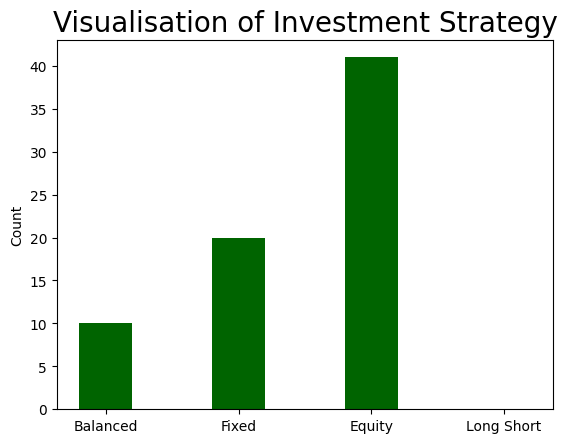

In [98]:
predic = {"Balanced":balanced_4, "Fixed":fixed_4, "Equity":equity_4, "Long Short":long_short_4}
headers = list(predic.keys())
rates = list(predic.values())
plt.bar(headers, rates, color = "darkgreen", width = 0.4)
plt.ylabel("Count")
plt.title("Visualisation of Investment Strategy", size = 20)
plt.show()

### SVM Results, 3 strategies:

In [99]:
balanced_3 = 0
fixed_3 = 0
equity_3 = 0
for idx, i in enumerate(y_pred_SVC_new):
  if i == 1:
    balanced_3 += 1
  elif i == 2:
    fixed_3 += 1
  else:
    equity_3 += 1
print(f"{balanced_3} mutual funds have a Balanced Fund investment strategy, {fixed_3} have a Fixed Income Long Only strategy, \nand {equity_3} mutual funds have an Equity Long Only strategy according to the SVM classifier.")

13 mutual funds have a Balanced Fund investment strategy, 19 have a Fixed Income Long Only strategy, 
and 38 mutual funds have an Equity Long Only strategy according to the SVM classifier.


In [100]:
total3 = balanced_3 + fixed_3 + equity_3
balanced_per3 = balanced_3 / total3 * 100
fixed_per3 = fixed_3 / total3 * 100
equity_per3 = equity_3 / total3 * 100
print("The ratio of companies with a balanced fund strategy is: %.2f %%"% balanced_per3)
print("The ratio of companies with a fixed income strategy is: %.2f %%"% fixed_per3)
print("The ratio of companies with an equity long only strategy is: %.2f %%"% equity_per3)

The ratio of companies with a balanced fund strategy is: 18.57 %
The ratio of companies with a fixed income strategy is: 27.14 %
The ratio of companies with an equity long only strategy is: 54.29 %


Creating bar plot representing prediction:

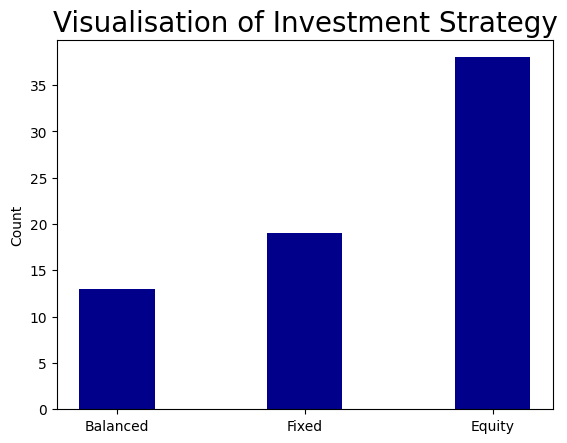

In [101]:
predic = {"Balanced":balanced_3, "Fixed":fixed_3, "Equity":equity_3}
headers = list(predic.keys())
rates = list(predic.values())
plt.bar(headers, rates, color = "darkblue", width = 0.4)
plt.ylabel("Count")
plt.title("Visualisation of Investment Strategy", size = 20)
plt.show()